In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
import os

import torch
from torchvision.ops import nms

import onnxruntime as ort
import onnx
from onnx import compose
from onnx import helper, TensorProto

from landmark_detection.extract import CVNet_SG 

In [2]:
# Funciones
def show_image(img_rgb):    
    # Mostrar la imagen original
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

def show_yolo_results(results):
    # Extraer detecciones del primer batch
    res0 = results[0]
    boxes = res0.boxes.xyxy.cpu().numpy()   # (N,4): x1,y1,x2,y2 en píxeles [0–639]
    scores = res0.boxes.conf.cpu().numpy()  # (N,)
    cls = res0.boxes.cls.cpu().numpy().astype(int)  # (N,)

    # Visualizar bounding boxes
    show_yolo_onnx_results(boxes, cls, scores)

def show_yolo_onnx_results(boxes, cls, scores):
    print(f"Encontradas {len(boxes)} cajas:")
    for i in range(len(boxes)):
        x1,y1,x2,y2 = boxes[i]
        class_name = class_names[cls[i]]
        print(f"  Clase {cls[i]} {class_name} @ {scores[i]:.2f} → [{x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f}]")
        
    plt.figure(figsize=(6,6))
    plt.imshow(img_resized)
    ax = plt.gca()
    
    for (x1,y1,x2,y2), cls, sc in zip(boxes, cls, scores):
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False, linewidth=2, edgecolor='red'
        )
        ax.add_patch(rect)
        class_name = class_names[cls]
        ax.text(
            x1, y1 - 4,
            f"{class_name}:{sc:.2f}",
            color='white', fontsize=9,
            bbox=dict(facecolor='red', alpha=0.5)
        )
    
    plt.axis('off')
    plt.show()

def show_crops(image, boxes, scores, classes, cols=4, figsize=(12, 12)):
    """
    Recibe la imagen original, los bounding boxes, scores y clases, 
    y muestra los crops en una cuadrícula con su clase y score.

    Args:
        image (torch.Tensor o np.ndarray): Imagen de entrada. Puede tener forma:
            - (1, 3, H, W) o (3, H, W) en torch.Tensor
            - (H, W, 3) o (3, H, W) en np.ndarray
        boxes (torch.Tensor o np.ndarray): Tensor o arreglo de NumPy con forma (N, 4), 
            donde cada fila es (x1, y1, x2, y2).
        scores (torch.Tensor o np.ndarray): Tensor o arreglo de NumPy con forma (N,), puntuaciones de confianza.
        classes (torch.Tensor o np.ndarray): Tensor o arreglo de NumPy con forma (N,), índices de clases.
        cols (int): Número de columnas en la cuadrícula.
        figsize (tuple): Tamaño de la figura matplotlib (ancho, alto).
        class_names (dict o list, opcional): Diccionario o lista para mapear índices de clase a nombres.
            Si se provee, se mostrará el nombre; en caso contrario, se mostrará el índice numérico.

    Ejemplo de uso:
        show_crops(image, boxes, scores, classes, cols=4, figsize=(12, 12), class_names={0: 'person', 1: 'car'})
    """
    # Convertir imagen a numpy (H, W, 3) en rango [0,1]
    if isinstance(image, torch.Tensor):
        img = image.detach().cpu()
        if img.ndim == 4:  # (1, 3, H, W)
            img = img[0]
        if img.ndim == 3 and img.shape[0] == 3:  # (3, H, W)
            img = img.permute(1, 2, 0)  # → (H, W, 3)
        img = img.numpy()
    else:
        img = np.array(image)
        if img.ndim == 3 and img.shape[0] == 3:  # (3, H, W)
            img = np.transpose(img, (1, 2, 0))
    
    # Si los valores no están en [0,1], escalar
    if img.max() > 1.0:
        img = img / 255.0
    
    # Convertir boxes, scores, classes a numpy
    if isinstance(boxes, torch.Tensor):
        boxes_np = boxes.detach().cpu().numpy()
    else:
        boxes_np = np.array(boxes)
    if isinstance(scores, torch.Tensor):
        scores_np = scores.detach().cpu().numpy()
    else:
        scores_np = np.array(scores)
    if isinstance(classes, torch.Tensor):
        classes_np = classes.detach().cpu().numpy()
    else:
        classes_np = np.array(classes)
    
    N = boxes_np.shape[0]
  
    # Calcular filas según columnas
    rows = (N + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(rows * cols):
        ax = axes[i]
        if i < N:
            x1, y1, x2, y2 = boxes_np[i].astype(int)
            crop = img[y1:y2+1, x1:x2+1, :]
            ax.imshow(crop)
            
            cls_idx = int(classes_np[i])
            score = float(scores_np[i])
            if class_names is not None and cls_idx in class_names:
                label = f"{class_names[cls_idx]}: {score:.2f}"
            else:
                label = f"Clase {cls_idx}: {score:.2f}"
           
            ax.set_title(label, fontsize=8)
            ax.axis("off")
        else:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [6]:
# Paths
IMAGE_PATH = os.path.join("datasets", "roxford5k", "jpg", "radcliffe_camera_000512.jpg")
YOLO_WEIGHTS_PATH = os.path.join("models", "yolov8n-oiv7.pt")
EXTRACTION_ONNX_PATH = os.path.join("models", "cvnet-sg-v0.onnx")
PIPELINE_ONNX_PATH = os.path.join("models", "pipeline-yolo-cvnet-sg.onnx")

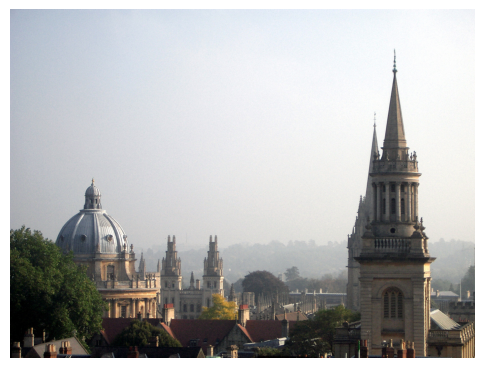

In [7]:
# Carga de imagen
img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

show_image(img_rgb)

In [8]:
# Preprocesado
image_dim = (640,640)

# Redimensionar a 640×640
img_resized = cv2.resize(img_rgb, image_dim)

# Convertir a tensor CHW y normalizar a [0,1] float32
img_tensor = torch.from_numpy(img_resized).permute(2,0,1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # shape (1,3,640,640)

print("Tensor shape:", img_tensor.shape, "dtype:", img_tensor.dtype)

Tensor shape: torch.Size([1, 3, 640, 640]) dtype: torch.float32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.89M/6.89M [00:02<00:00, 3.61MB/s]


Número de clases del modelo: 601

0: 640x640 2 Buildings, 2 Towers, 5 Trees, 398.1ms
Speed: 1.1ms preprocess, 398.1ms inference, 17.2ms postprocess per image at shape (1, 3, 640, 640)
Encontradas 9 cajas:
  Clase 553 Tree @ 0.67 → [0.1,390.6,137.0,636.2]
  Clase 546 Tower @ 0.65 → [454.8,90.2,594.5,634.6]
  Clase 553 Tree @ 0.19 → [256.5,520.8,315.5,572.5]
  Clase 553 Tree @ 0.19 → [377.7,539.4,487.5,639.2]
  Clase 553 Tree @ 0.17 → [138.1,566.8,232.4,635.8]
  Clase 553 Tree @ 0.16 → [308.0,476.7,386.7,565.3]
  Clase 546 Tower @ 0.14 → [57.7,307.6,203.5,589.9]
  Clase 70 Building @ 0.13 → [47.4,308.2,312.5,618.5]
  Clase 70 Building @ 0.11 → [56.8,307.7,203.8,593.9]


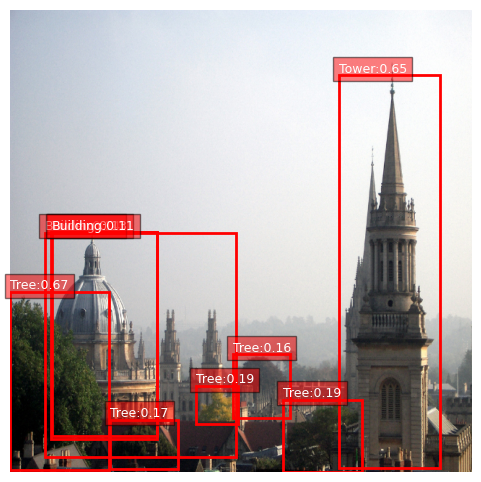

In [9]:
# Inferencia con el modelo .pt
model = YOLO(YOLO_WEIGHTS_PATH)
class_names = model.names
print("Número de clases del modelo:", len(model.names))

results = model(img_tensor, imgsz=image_dim, conf=0.1)      # devuelve lista de Results
show_yolo_results(results)

Encontradas 7 cajas:
  Clase 553 Tree @ 0.67 → [0.1,390.6,137.0,636.2]
  Clase 546 Tower @ 0.65 → [454.8,90.2,594.5,634.6]
  Clase 553 Tree @ 0.19 → [256.5,520.8,315.5,572.5]
  Clase 553 Tree @ 0.19 → [377.7,539.4,487.5,639.2]
  Clase 553 Tree @ 0.17 → [138.1,566.8,232.4,635.8]
  Clase 553 Tree @ 0.16 → [308.0,476.7,386.7,565.3]
  Clase 546 Tower @ 0.14 → [57.7,307.6,203.5,589.9]


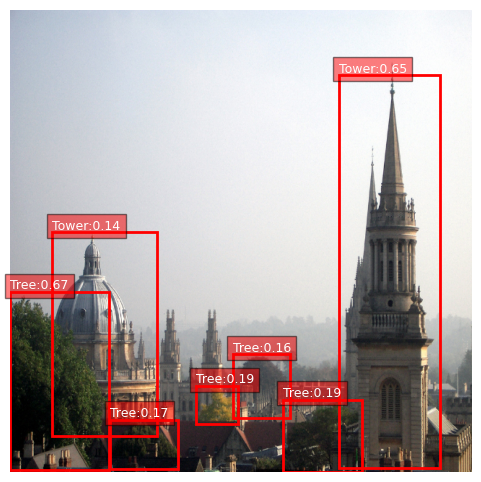

In [13]:
# Visualizar resultados ONNX
show_yolo_onnx_results(yolo_onnx_boxes, yolo_onnx_cls, yolo_onnx_scores)

In [16]:
raw_pred = torch.from_numpy(onnx_out)
oiv7_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,514,524,530,531,543,546,554,565,573,580,587,588,591]
pipeline = CVNet_SG(oiv7_classes)
pipeline.eval()
with torch.no_grad():
    final_boxes, final_classes = pipeline(raw_pred, img_tensor)

In [13]:
from torchvision.ops import nms
# Decodificar coordenadas y extraer cls_conf + cls_ids
boxes_all, scores_all, classes_all = pipeline._decode_and_score(raw_pred)

# Non-Maximum Suppression (NMS) sobre todas las detecciones decodificadas
keep_nms2 = nms(boxes_all, scores_all, iou_threshold=0.45)
boxes_nms   = boxes_all[keep_nms2]    # (R, 4)
scores_nms  = scores_all[keep_nms2]   # (R,)
classes_nms = classes_all[keep_nms2]  # (R,)

# Filtrar por umbral de score + pertenencia a allowed_classes
boxes_filt, scores_filt, classes_filt = pipeline._filter_by_score_and_class(
    boxes_nms, scores_nms, classes_nms
)

# Añadir siempre la “detección” de la imagen completa al inicio
_, _, H, W = img_tensor.shape
full_box = torch.tensor(
    [[0.0, 0.0, float(W - 1), float(H - 1)]],
    dtype=boxes_filt.dtype,
    device=boxes_filt.device
)  # (1, 4)
full_score = torch.tensor(
    [1.0],
    dtype=scores_filt.dtype,
    device=scores_filt.device
)  # (1,)
full_class = torch.tensor(
    [0],
    dtype=classes_filt.dtype,
    device=classes_filt.device
)  # (1,)

final_boxes   = torch.cat([full_box, boxes_filt], dim=0)    # (M+1, 4)
final_scores  = torch.cat([full_score, scores_filt], dim=0) # (M+1,)
final_classes = torch.cat([full_class, classes_filt], dim=0)# (M+1,)

# Escalar todas las cajas según las escalas definidas
scaled_boxes = pipeline._scale_boxes(final_boxes, img_tensor.shape, [0.7071, 1.0, 1.4142])
# scaled_boxes: shape (M+1, K, 4)

crops = pipeline._extract_and_resize_crops(scaled_boxes, img_tensor)

# Normalizar crops usando función aparte
crops_norm = pipeline._normalize_crops(crops)

# Obtener mapas de activación
with torch.no_grad():
    feature_maps = pipeline.cvnet(crops_norm) 

# Obtener mapas de activación
with torch.no_grad():
    feature_maps = pipeline.cvnet(crops_norm) 
    descriptors = pipeline.sg(feature_maps, 3)

In [14]:
from PIL import Image
def save_tensor_images(tensor_batch: torch.Tensor, output_dir: str = ".", prefix: str = "image"):
    """
    Guarda cada imagen de un tensor de forma (N, 3, H, W) como un archivo JPEG.

    Args:
        tensor_batch (torch.Tensor): Tensor de forma (N, 3, H, W). 
                                     Se asume valores en [0,1] o [0,255].
        output_dir (str): Directorio donde se guardarán las imágenes. Por defecto, el directorio actual.
        prefix (str): Prefijo para el nombre de los archivos. Se generarán "prefix_0.jpg", "prefix_1.jpg", etc.
    """
    # Asegurarse de que el directorio existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Mover a CPU y desenganchar de la gráfica, si es necesario
    tensor_batch = tensor_batch.detach().cpu()
    
    # Verificar rango de valores: ¿están en [0,1]?
    if tensor_batch.max() <= 1.0:
        tensor_batch = tensor_batch * 255.0
    
    # Convertir a uint8
    tensor_batch = tensor_batch.clamp(0, 255).to(torch.uint8)
    
    N, C, H, W = tensor_batch.shape
    for i in range(N):
        img_tensor = tensor_batch[i]  # (3, H, W)
        # Permutar a (H, W, 3)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        # Crear imagen PIL y guardar
        img_pil = Image.fromarray(img_np)
        filename = os.path.join(output_dir, f"{prefix}_{i}.jpg")
        img_pil.save(filename, format="JPEG")
        print(f"Guardado: {filename}")

In [15]:
save_tensor_images(crops)

Guardado: .\image_0.jpg
Guardado: .\image_1.jpg
Guardado: .\image_2.jpg
Guardado: .\image_3.jpg
Guardado: .\image_4.jpg
Guardado: .\image_5.jpg
Guardado: .\image_6.jpg
Guardado: .\image_7.jpg
Guardado: .\image_8.jpg
Guardado: .\image_9.jpg
Guardado: .\image_10.jpg
Guardado: .\image_11.jpg
Guardado: .\image_12.jpg
Guardado: .\image_13.jpg
Guardado: .\image_14.jpg


In [16]:
descriptors.shape

torch.Size([5, 2048])

In [17]:
(descriptors[0] != descriptors[1]).sum()

tensor(2048)

Encontradas 5 cajas:
  Clase 0 Accordion @ 1.00 → [0.0,0.0,639.0,639.0]
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]


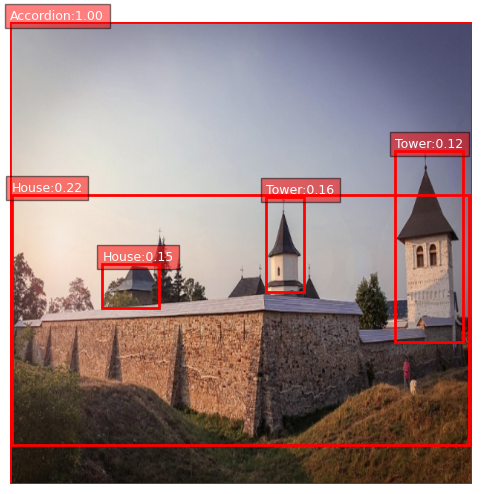

In [18]:
show_yolo_onnx_results(final_boxes.numpy(), final_classes.numpy(), final_scores.numpy())

Encontradas 5 cajas:
  Clase 0 Accordion @ 1.00 → [0.0,0.0,639.0,639.0]
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]


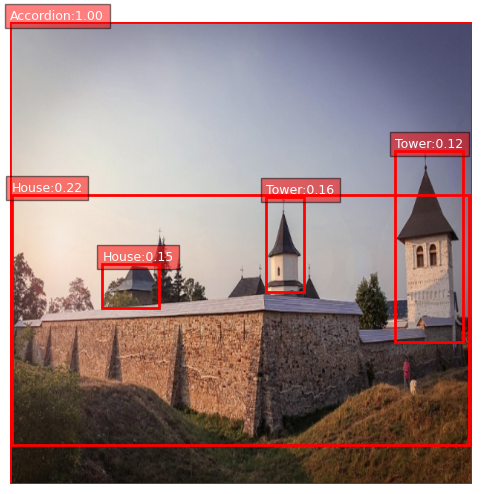

In [19]:
# Visualizar resultados Pipeline
show_yolo_onnx_results(final_boxes.numpy(), final_classes.numpy(), final_scores.numpy())

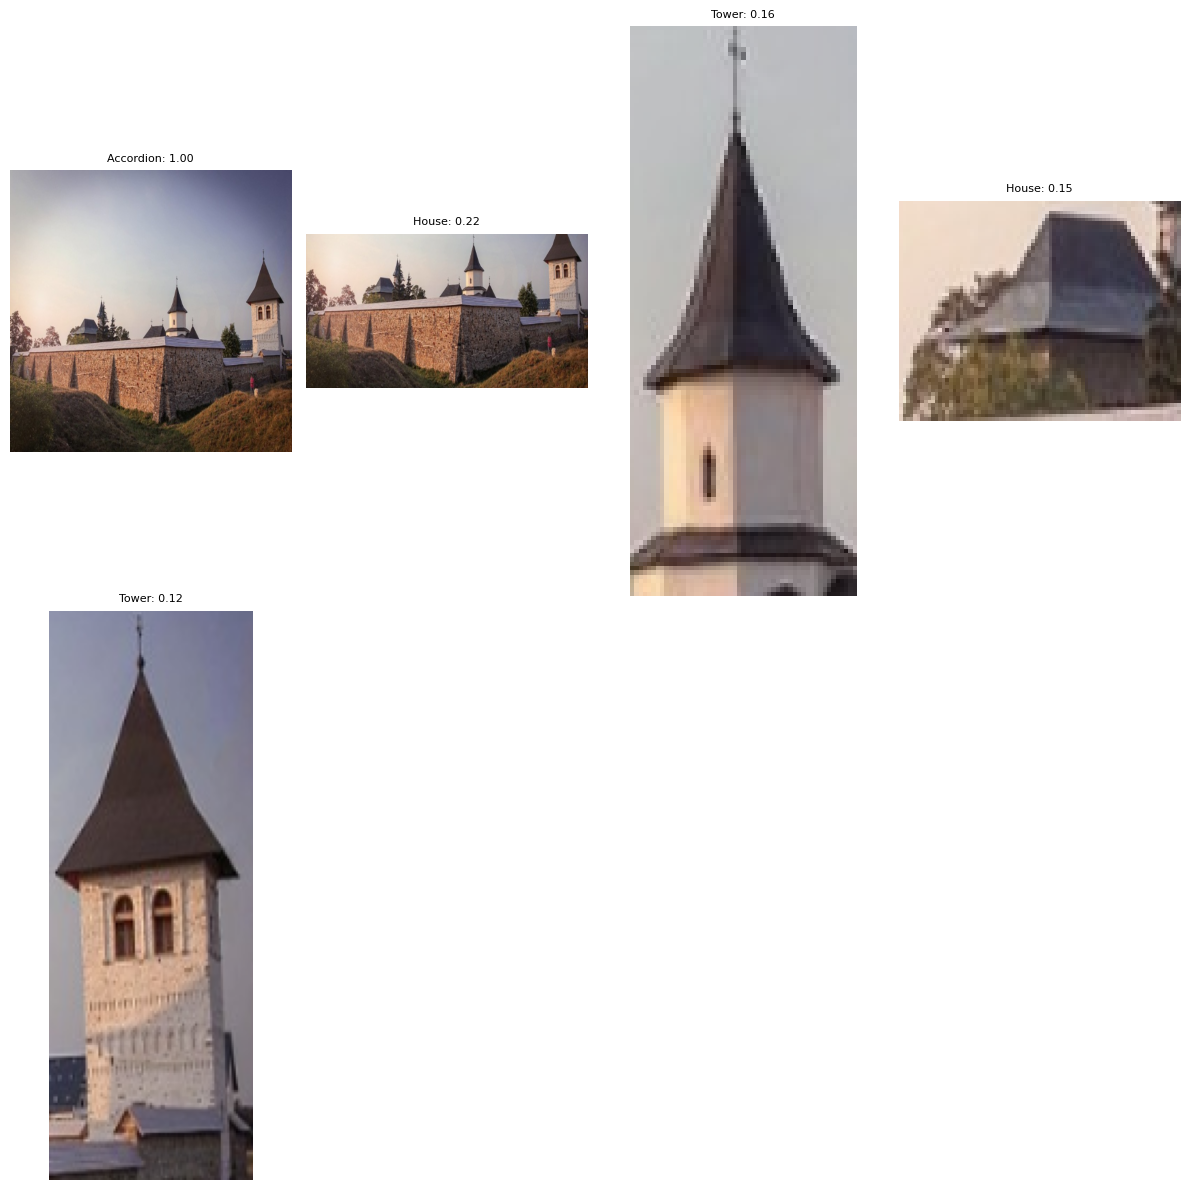

In [20]:
show_crops(img_tensor, final_boxes, final_scores, final_classes)

In [21]:
# Exportar a ONNX
torch.onnx.export(
    pipeline,
    (raw_pred, img_tensor),
    EXTRACTION_ONNX_PATH,
    opset_version=16,                   # OPS versión >= 11 para NMS
    input_names=["output0", "p_images"],           # nombre del input
    output_names=["boxes", "scores", "classes", "crops"],
    dynamic_axes={
        "boxes":    {0: "num_boxes"},   
        "scores":   {0: "num_boxes"},
        "classes":  {0: "num_boxes"},
        "crops":    {0: "num_boxes"}  
   },
    do_constant_folding=True
)

In [22]:
# Cargar el modelo YOLO original
model = onnx.load(yolo_onnx_path)
graph = model.graph

# Identificar el nombre del input de YOLO
input_name = graph.input[0].name
print(f"YOLO input detectado: {input_name}")

# Crear un nodo Identity que copie ese input a un nuevo tensor "images_out"
identity_node = helper.make_node(
    "Identity",
    inputs=[input_name],      # la entrada original de YOLO ("images")
    outputs=["images_out"],   # nuevo nombre de tensor que contendrá la misma imagen
    name="Identity_ExposeImages"
)

# Añadir ese nodo al final de graph.node
graph.node.append(identity_node)

# Declarar “images_out” como nuevo output del grafo, con la misma shape/dtipo que "images"
# Podemos extraer la shape/dtipo del input para no recortarla a mano:
input_type = graph.input[0].type.tensor_type.elem_type  # debería ser FLOAT (1)
input_shape = []
for dim in graph.input[0].type.tensor_type.shape.dim:
    # Si el dim_value > 0, lo tomamos; si es simbólico, dejamos dim_param
    if dim.dim_value > 0:
        input_shape.append(dim.dim_value)
    else:
        input_shape.append(dim.dim_param)

new_output = helper.make_tensor_value_info(
    name="images_out",
    elem_type=input_type,
    shape=input_shape
)
graph.output.append(new_output)

# 1.6) Guardar el ONNX modificado en disco
onnx.save(model, yolo_onnx_path)

YOLO input detectado: images


In [23]:
# 1) Cargar ambos modelos
yolo_model = onnx.load(yolo_onnx_path)
pp_model   = onnx.load(EXTRACTION_ONNX_PATH)

merged_model = compose.merge_models(
    yolo_model,
    pp_model,
    io_map=[("images_out", "p_images"),("output0", "output0")]
)

onnx.checker.check_model(merged_model)  # valida topológica y esquemas
onnx.save(merged_model, PIPELINE_ONNX_PATH)

In [24]:
# Cargar sesión ONNX
sess = ort.InferenceSession(PIPELINE_ONNX_PATH, providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name

# Ejecutar inferencia sobre el tensor preparado (batch,3,640,640)
final_boxes, final_scores, final_classes, descriptors = sess.run(None, {input_name: img_tensor.numpy()})

Encontradas 5 cajas:
  Clase 0 Accordion @ 1.00 → [0.0,0.0,639.0,639.0]
  Clase 257 House @ 0.22 → [2.0,238.7,635.2,585.8]
  Clase 546 Tower @ 0.16 → [354.2,241.3,406.4,373.2]
  Clase 257 House @ 0.15 → [127.6,334.5,205.9,395.8]
  Clase 546 Tower @ 0.12 → [533.4,177.8,627.1,442.1]


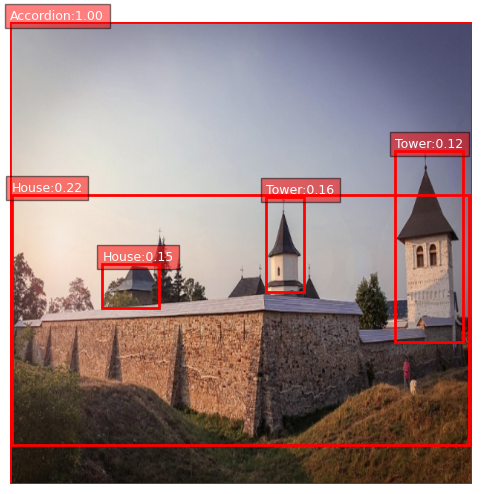

In [25]:
# Visualizar resultados Pipeline
show_yolo_onnx_results(final_boxes, final_classes, final_scores)

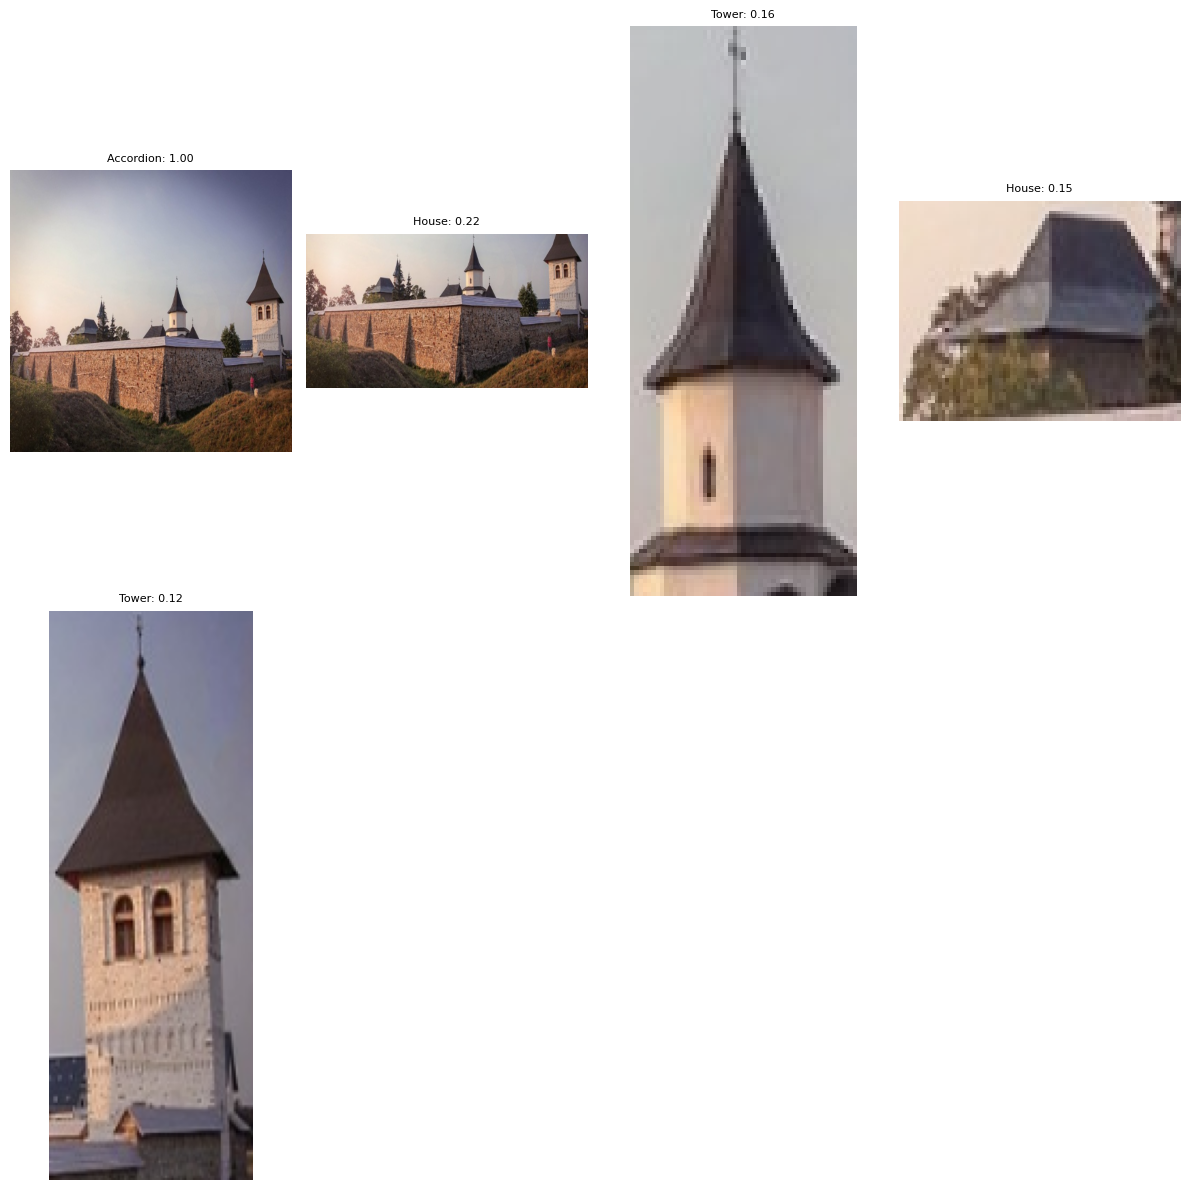

In [26]:
show_crops(img_tensor, final_boxes, final_scores, final_classes)

In [27]:
descriptors.shape

(5, 2048)

In [28]:
(descriptors[0] != descriptors[1]).sum()

np.int64(2048)